In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
import math
from sklearn.model_selection import KFold


from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *


import scoping.utils.learning_utils as lu
import random


double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)


now=datetime.datetime.now()

## First we say what query and project we are interested in

In [2]:
pid = 217
qid = 7966
q = Query.objects.get(pk=qid)
p = Project.objects.get(pk=pid)

print(q.doc_set.count())
q.r_count

94944


94944

### And we retrieve those documents that have been screened in that query

In [3]:
docs = Doc.objects.filter(query=q, content__iregex='\w').values_list('pk', flat=True)

print(docs.count())

seen = set(DocOwnership.objects.filter(
    query=q, 
    relevant__gt=0
).values_list('doc__pk', flat=True))


seen = seen & set(docs)

seen_docs = Doc.objects.filter(pk__in=seen)
seen_docs.count()

94944


3847

### We have a separate list of documents in the query that have not been screened

In [4]:
unseen_docs = docs.exclude(pk__in=seen).distinct('id')

unseen_docs.count()

columns = [
    'id',
    'content',
    'title',
    'wosarticle__de',
    'wosarticle__wc'
]

unseen_df = pd.DataFrame.from_dict(list(unseen_docs.values(*columns)))
unseen_df = unseen_df[columns]
unseen_df['relevant'] = 0
unseen_df['seen'] = 0

print(unseen_df.shape)
unseen_df.head()

(91097, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,4,"In America, entertainment celebrities have ent...","From sidekick to sideshow - Celebrity, enterta...",politics of distraction; celebrity politics; c...,"[Psychology, Clinical; Social Sciences, Interd...",0,0
1,20,The responsiveness of South African fauna to c...,Vulnerability of South African animal taxa to ...,conservation; fragmentation; land-use; range c...,[Biodiversity Conservation; Ecology; Environme...,0,0
2,29,In an stylized endogenous growth economy with ...,Optimal green tax reforms yielding double divi...,Double dividend; Emissions tax; Dynamic Laffer...,[Economics; Energy & Fuels; Environmental Scie...,0,0
3,65,The world's increasing need is to develop smar...,Synthesis of a Cementitious Material Nanocemen...,None,[Nanoscience & Nanotechnology; Materials Scien...,0,0
4,74,Numerous epidemiological studies have demonstr...,Particulate matter in the indoor air of classr...,indoor; schools; classrooms; particulate matte...,[Environmental Sciences; Meteorology & Atmosph...,0,0


### We gather the screening decisions (relevant=1, not relevant=0) and make a dataframe from them

In [5]:
rated = list(seen_docs.values(*columns))
r_docs = []
for r in rated:
    d = Doc.objects.get(pk=r['id'])

    dos = DocOwnership.objects.filter(
        query__project=p,doc=d,relevant__gt=0,
    ).values_list('relevant',flat=True)
    if not dos.exists():
        dos = DocOwnership.objects.filter(
            project=p,doc=d,relevant__gt=0,
        ).values_list('relevant',flat=True)            
    if len(set(dos))==1: # If there is only one value (all ratings agree)
        if dos[0] == 1:
            r['relevant'] = 1
        elif dos[0] == 2 or dos[0] == 4:
            r['relevant'] = 0
        else:
            continue
        r_docs.append(r)
    
        
seen_df = pd.DataFrame.from_dict(r_docs)
seen_df = seen_df[columns + ["relevant"]]
seen_df['seen'] = 1
print(seen_df.shape)
seen_df.head()

(3781, 7)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,778345,Finding the right balance between centralizati...,Ambitious climate policy through centralizatio...,Centralization; climate policy; decentralizati...,[Environmental Studies; Public Administration],1,1
1,437137,Based on qualitative research and a case study...,Triggering Community Conservation Through the ...,community conservation; market-based instrumen...,[Development Studies; Environmental Studies; R...,1,1
2,1307625,Mixed coniferous forests are widespread at mid...,Millennial scale climate-fire-vegetation inter...,Fire history; Vegetation history; Mixed-conife...,"[Geography, Physical; Geosciences, Multidiscip...",1,1
3,732075,We critically review the Kyoto Protocol and th...,Thirteen plus one: a comparison of global clim...,policy architecture; Kyoto Protocol; efficienc...,[Environmental Studies; Public Administration],1,1
4,785897,This paper analyzes hybrid emissions trading s...,Combining price and quantity controls under pa...,Emission trading; Hybrid regulation; Partition...,[Economics],1,1


### And we merge the two, with a column "seen" recording if a document has been seen or not

In [6]:
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .reset_index(drop=True)
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
     )
y = df['relevant']
df.head()

,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen
0,199087,Purpose - The purpose of this paper is to prov...,Making the case for gender sensitive climate p...,Gender inequality; Climate justice; Wheat; Soc...,[Environmental Studies],0,0
1,356981,In the context of climate change mitigation an...,Toward policies for climate change mitigation:...,Biogas energy; Local Governance; Ordinary Leas...,"[Environmental Sciences; Geosciences, Multidis...",0,0
2,718231,This study evaluates the equilibrium response ...,Equilibrium response of thermohaline circulati...,None,[Meteorology & Atmospheric Sciences],0,0
3,1900660,The Greenhouse Gases Observing SATellite (GOSA...,The instrumentation and the contamination cont...,Fourier transform spectrometer; contamination ...,"[INSTRUMENTS & INSTRUMENTATION, OPTICS]",0,0
4,899607,This article describes the design of a new mod...,A model-based assessment of the environmental ...,Assessment framework; Land-use change; Souther...,[Environmental Sciences; Environmental Studies],0,0


### We also get the assignments of these documents to categories, and add these as further columns in our dataframe

In [7]:
cats = Category.objects.filter(project=p)
ldf = pd.DataFrame.from_dict(list(seen_docs.filter(
    category__in=cats
).values('id','category__name')))
ldf['v'] = 1

cat_map = ldf.pivot(index='id',columns="category__name", values="v")
cat_map['id'] = cat_map.index
cat_map = cat_map.reset_index(drop=True)

df = pd.merge(df, cat_map, how="left").fillna(0)
print(df.shape)
df.head()

(94878, 52)


,id,content,title,wosarticle__de,wosarticle__wc,relevant,seen,<hidden>tax/emission trading,Adaptation,Behavioral interventions,...,Spatial & land-use planning,Sub-national/ regional,Subsidies<hidden>,Subsidy/compensation/ allowance,Supranational & international,Targets & goals,Tax,Voluntary actions,Voluntary agreements,voluntary agreement<hidden>
0,199087,Purpose - The purpose of this paper is to prov...,Making the case for gender sensitive climate p...,Gender inequality; Climate justice; Wheat; Soc...,[Environmental Studies],0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,356981,In the context of climate change mitigation an...,Toward policies for climate change mitigation:...,Biogas energy; Local Governance; Ordinary Leas...,"[Environmental Sciences; Geosciences, Multidis...",0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,718231,This study evaluates the equilibrium response ...,Equilibrium response of thermohaline circulati...,0,[Meteorology & Atmospheric Sciences],0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1900660,The Greenhouse Gases Observing SATellite (GOSA...,The instrumentation and the contamination cont...,Fourier transform spectrometer; contamination ...,"[INSTRUMENTS & INSTRUMENTATION, OPTICS]",0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,899607,This article describes the design of a new mod...,A model-based assessment of the environmental ...,Assessment framework; Land-use change; Souther...,[Environmental Sciences; Environmental Studies],0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### We have a look at the distribution of relevant and not relevant documents

Text(0, 0.5, 'Number of documents')

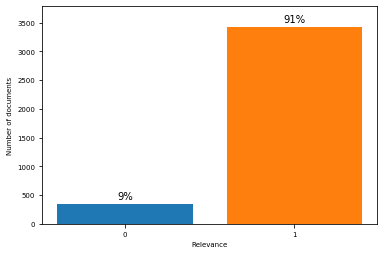

In [8]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
y = df['relevant']
for i, (name, group) in enumerate(seen_df.groupby('relevant')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")

ax.set_xticks([0,1])
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xlabel('Relevance')
ax.set_ylabel('Number of documents')

### Now we "vectorize" the data, representing each document as a weighted count of its words and phrases (bag of words and bigrams). Or if we already did this previously, then we reload the vectorized data

In [10]:
import pickle
revectorize = False
y = df['relevant']
if revectorize:
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=4, max_df=0.8, strip_accents='unicode', 
        max_features=10000,
        use_idf=1,
        smooth_idf=1, sublinear_tf=1,
        stop_words="english",tokenizer=learning_utils.tokenize
    )
    ab_X = vec.fit_transform(df['content'])
    with open ('data/vec.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz('data/X.npz', ab_X)
else:
    with open ('data/vec.pickle','rb') as f:
        vec = pickle.load(f)
    ab_X = scipy.sparse.load_npz('data/X.npz')

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

### We build 3 types of classifiers, and test these with k-fold cross validation

In [13]:
from sklearn.model_selection import KFold

models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

models = lu.cross_validate_models(ab_X, y, models, seen_index)

1
2
3
4
5
6
7
8
9
10


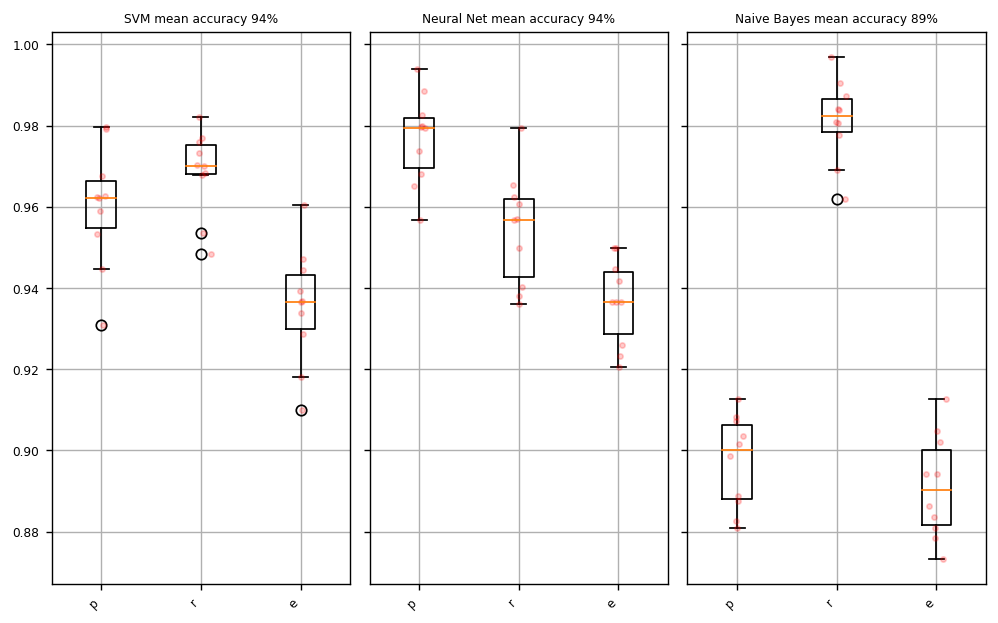

In [15]:
fig, axs = plt.subplots(1, len(models),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(models,  ['p','r','e'], fig, axs)
plt.show()

In [16]:
model_df = pd.DataFrame(models)
model_df.to_csv(f"doctables/models_relevance_{now}.csv",index=False)

### We can choose the best performing model (for our purposes) and fit it on our unseen data, in order to predict the probability that our unseen documents are relevant

In [17]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear',class_weight='balanced',probability=True)

y = df['relevant']

clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

76654 out of 91097 documents are predicted to be relevant


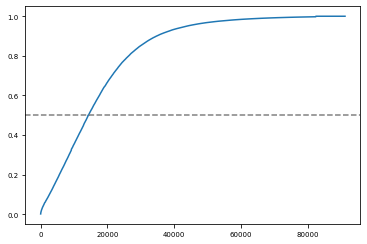

In [18]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

rel = df[pdf['prediction']>0.5].shape[0]
tot = pdf[pdf['prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

df[['id','prediction']].to_csv(f'doctables/predictions_{now}.csv',index=False)

plt.show()



### Now we make a new random sample

In [ ]:
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

In [ ]:
t1, created = Tag.objects.get_or_create(
    title="predicted relevant sample {}".format(now),
    query=q
)
t1.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 500
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  

    
t1.update_tag()
            
t1.update_tag()

## Now we try and predict governance and policies

Text(0.5, 0, 'Governance & policies')

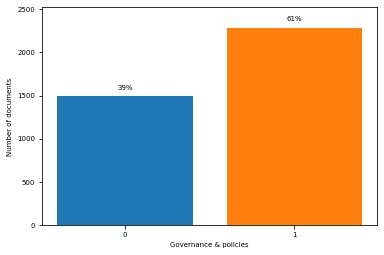

In [22]:
fig, ax = plt.subplots()
n = seen_df.shape[0]
for i, (name, group) in enumerate(df[df['seen']==1].groupby('Governance & policies')):
    ax.bar(i, group.shape[0])
    ax.text(i, group.shape[0]+n*0.02, f'{group.shape[0]/n:.0%}',ha="center")
    
ax.set_ylim(ymax=ax.get_ylim()[1]*1.05)
ax.set_xticks([0,1])
ax.set_ylabel('Number of documents')
ax.set_xlabel('Governance & policies')

In [23]:
from sklearn.model_selection import KFold

y = df['Governance & policies']
gov_models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',class_weight='balanced',probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]

gov_models = lu.cross_validate_models(ab_X, y, gov_models, seen_index)

1
2
3
4
5
6
7
8
9
10


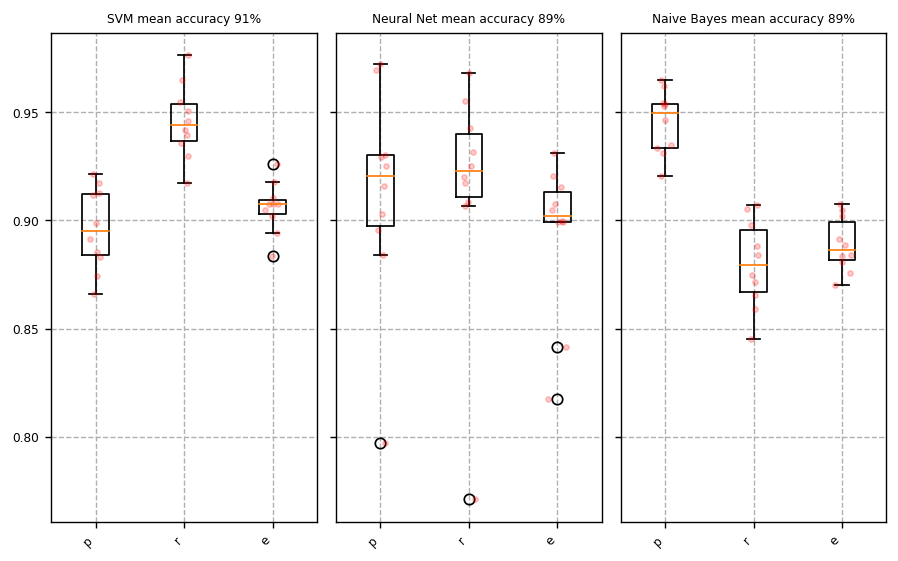

In [27]:

fig, axs = plt.subplots(1,3,dpi=125,figsize=double_figure,sharey=True)
lu.plot_model_output(gov_models,  ['p','r','e'], fig, axs)
plt.show()

In [28]:
model_df = pd.DataFrame(models)
model_df.to_csv(f"doctables/models_governance_policies_{now}.csv",index=False)

In [ ]:
kf = KFold(n_splits=10)
i=0
all_mistakes = None
df['mispredicted'] = 0


all_fps = None
all_fns = None

for k_train, k_test in kf.split(seen_index):
    k_train = seen_index[k_train]
    k_test = seen_index[k_test]
    
    clf = SVC(kernel='linear',class_weight='balanced',probability=True)
    clf.fit(ab_X[k_train],y[k_train])
    
    y_pred = clf.predict_proba(ab_X[k_test])
    
    fns = np.argwhere((np.array(y[k_test])>0.5) & (y_pred[:,1] < 0.5))
    fps = np.argwhere((np.array(y[k_test])<0.5) & (y_pred[:,1] > 0.5))
    
    print(f"mean prediction for false +ves {y_pred[fps,1].mean()}")
    print(f"mean prediction for false -ves {y_pred[fns,1].mean()}")
    
    mistakes = np.append(fps,fns)
    
    df.loc[k_test[mistakes],'mispredicted'] = 1
    
    if all_fps is not None:
        all_fps = np.append(all_fps,y_pred[fps,1][:,0])
    else:
        all_fps = y_pred[fps,1][:,0]
    if all_fns is not None:
        all_fns = np.append(all_fns,y_pred[fns,1][:,0])
    else:
        all_fns = y_pred[fns,1][:,0]    
    


In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8, 4), dpi=150)
n, bins, patches = axs[1].hist(all_fps, 20, density=True, histtype='step',
                       cumulative=True, label='Empirical')

axs[1].plot([0.5,1],[0,1])

n, bins, patches = axs[0].hist(all_fns, 20, density=True, histtype='step',
                   cumulative=-1, label='Empirical')
axs[0].plot([0,0.5],[1,0])

plt.show()

In [ ]:
t1 = Tag(
    title="Governance & policies false positives and negatives {}".format(now),
    query=q
)
t1.save()
for i, row in df.query('mispredicted==1').iterrows():
    d = Doc.objects.get(pk=row['id'])
    d.tag.add(t1)
t1.update_tag()

In [ ]:
clf =  MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )

clf = SVC(kernel='linear',class_weight='balanced',probability=True)


clf.fit(ab_X[seen_index],y[seen_index])

y_pred = clf.predict_proba(ab_X[unseen_index])

In [ ]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = y_pred[:,1]

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])
print(pdf[pdf['prediction'].notna()].shape[0])

plt.show()

### Now we can make a new tag and screening decision objects with the x documents most likely to be relevant

In [ ]:
q = Query.objects.get(pk=qid)
q.users.all()

In [ ]:
import datetime


t1 = Tag(
    title="predicted policy sample {}".format(now),
    query=q
)
t1.save()

tag = t1

users = q.users.all()
uc = len(users)
max_docs = 500
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(t1)
            docs_added+=1
        else:
            break  

    
t1.update_tag()


In [ ]:
df[['id','prediction']].to_csv(f'doctables/predictions_{now}.csv',index=False)

## Now we want to look at mitigation and adaptation

In [29]:
df['mit/ad'] = df['Mitigation'] + df['Adaptation']
print("seen documents:",df.loc[df['seen']==1,].shape[0])
print("seen mitigation documents:", df.loc[df['seen']==1,'Mitigation'].sum())
print("seen adaptation documents", df.loc[df['seen']==1,'Adaptation'].sum())
print("seen mitigation and adaptation documents", df.loc[df['mit/ad']==2,].shape[0])
print("seen non-mit/ad documents",df.loc[(df['seen']==1) & (df['mit/ad']==0),].shape[0])

seen documents: 3781
seen mitigation documents: 2541.0
seen adaptation documents 1239.0
seen mitigation and adaptation documents 353
seen non-mit/ad documents 354


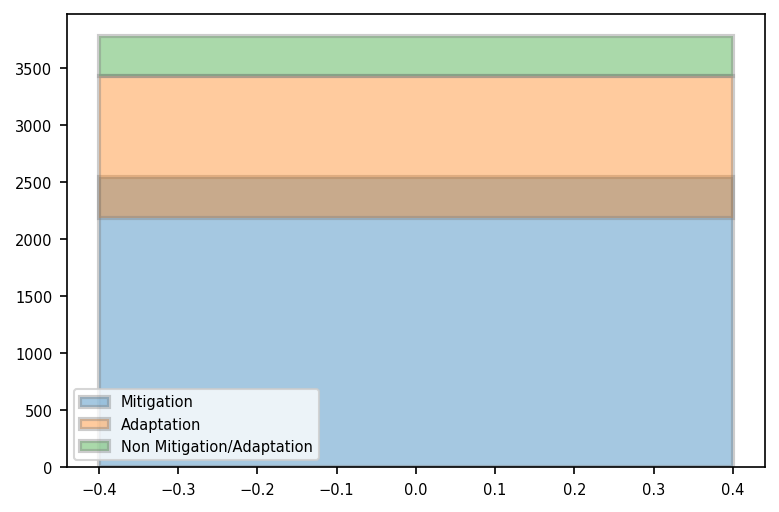

In [30]:
fig, ax = plt.subplots(dpi=150)

mitigation = df.loc[df['seen']==1,'Mitigation'].sum()
adaptation = df.loc[df['seen']==1,'Adaptation'].sum()
overlap = df.loc[df['mit/ad']==2,].shape[0]
nonmitad = df.loc[(df['seen']==1) & (df['mit/ad']==0),].shape[0]

lw = 2
alpha=0.4
ec = "grey"

ax.bar(
    0,mitigation,
    alpha=alpha, label="Mitigation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,adaptation,bottom=mitigation-overlap,
    alpha=alpha, label="Adaptation",
    lw=lw, edgecolor=ec
)
ax.bar(
    0,nonmitad,bottom=mitigation-overlap+adaptation,
    alpha=alpha, label="Non Mitigation/Adaptation",
    lw=lw, edgecolor=ec
)

ax.legend()

In [31]:
classes = ["Mitigation","Adaptation"]
y = np.matrix(df[classes])
y.shape

(94878, 2)

In [33]:
from sklearn.model_selection import KFold
multimodels = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels, metrics = lu.cross_validate_models(ab_X, y, multimodels, seen_index, classes=classes)


1
2
3
4
5
6
7
8
9
10


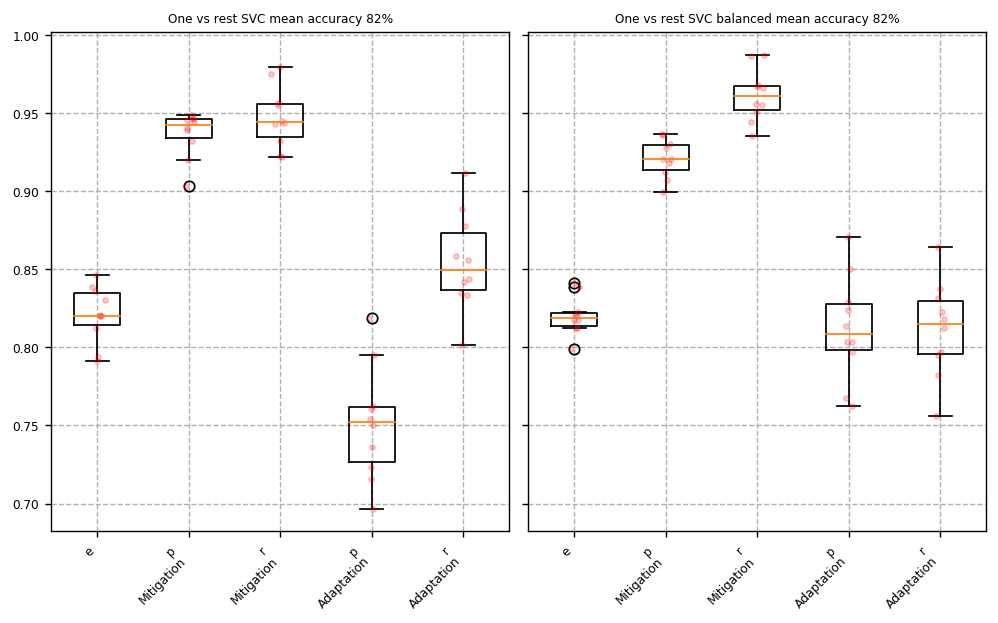

In [35]:
fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, metrics, fig, axs)
plt.show()

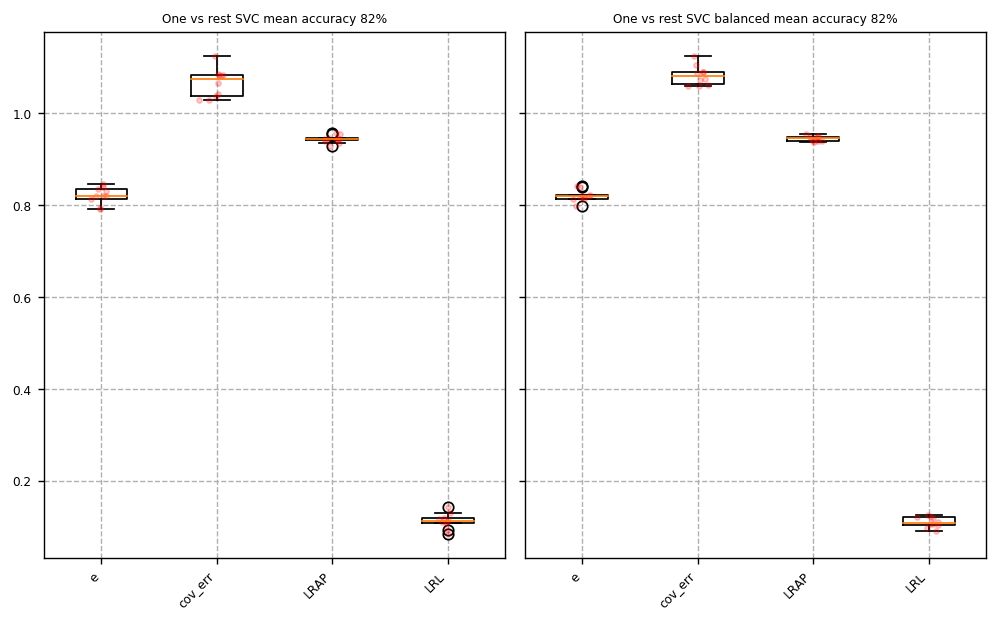

In [37]:
m_metrics = ['e','cov_err', 'LRAP','LRL']
fig, axs = plt.subplots(1, len(multimodels),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels, m_metrics, fig, axs)
plt.show()

In [51]:
model_df = pd.DataFrame(multimodels)
model_df.to_csv(f"doctables/multimodels_adaptation_mitigation_{now}.csv",index=False)

In [53]:
clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
classes = ["Mitigation","Adaptation"]
y = np.matrix(df[classes])
y.shape

clf.fit(ab_X[seen_index],y[seen_index])
predictions = clf.predict(ab_X[unseen_index])
both_predictions = predictions.sum(axis=1)//2

In [54]:
both_predictions

array([0, 1, 0, ..., 0, 0, 0])

6108 out of 91097 documents are predicted to be relevant


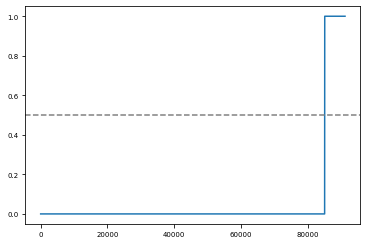

In [55]:
plt.close()

df['prediction'] = None
df.loc[unseen_index,'prediction'] = both_predictions

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

rel = df[pdf['prediction']>0.5].shape[0]
tot = pdf[pdf['prediction'].notna()].shape[0]


print(f"{rel} out of {tot} documents are predicted to be relevant")

df[['id','prediction']].to_csv(f'doctables/predictions_adaptation_mitigation_{now}.csv',index=False)

plt.show()

In [57]:
tag, created = Tag.objects.get_or_create(
    title="predicted mitigation&adaptation sample {}".format(now),
    query=q
)
tag.save()

max_docs = 100
docs_added = 0
for i, row in df.sort_values('prediction',ascending=False).head(3500).reset_index(drop=True).iterrows():
    d = Doc.objects.get(id=row['id'])
    if d.docownership_set.filter(query=q).exists():
        continue
    else:
        if docs_added < max_docs:
            d.tag.add(tag)
            docs_added+=1
        else:
            break  

    
tag.update_tag()

A discussion of the different metrics is provided here
https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics

In [40]:
django.db.connection.close()
cat_dict = {}
for c in Category.objects.filter(project=p):
    if c.child_category.exists():
        cat_dict[c.name.replace('<hidden>','').strip()] = list(
            c.child_category.values_list('name',flat = True)
        )
    
cat_dict

{'Adaptation': ['Information<hidden>',
  'Regulation<hidden>',
  '<hidden>tax/emission trading',
  'Subsidies<hidden>',
  'voluntary agreement<hidden>'],
 'Economic instruments': ['Emissions trading ',
  'Subsidy/compensation/ allowance',
  'Tax',
  'Investments, credits and loans',
  'Feed in tariffs'],
 'Goal setting': ['Targets & goals'],
 'Governance & policies': ['Voluntary actions',
  'Other<hidden>',
  'Goal setting',
  'International policies',
  'Regulatory instruments',
  'Planning and public provisioning/services',
  'Information policies',
  'Government procurement & public services<hidden>',
  'Economic instruments'],
 'Information policies': ['Reports and assessments/ monitoring and evaluation',
  'Labeling and certificates /Consumption and production choices',
  'Public information/ awareness campaigns'],
 'International policies': ['International agreements',
  'Financial mechanisms'],
 'Mitigation': ['Governance & policies'],
 'Planning and public provisioning/services

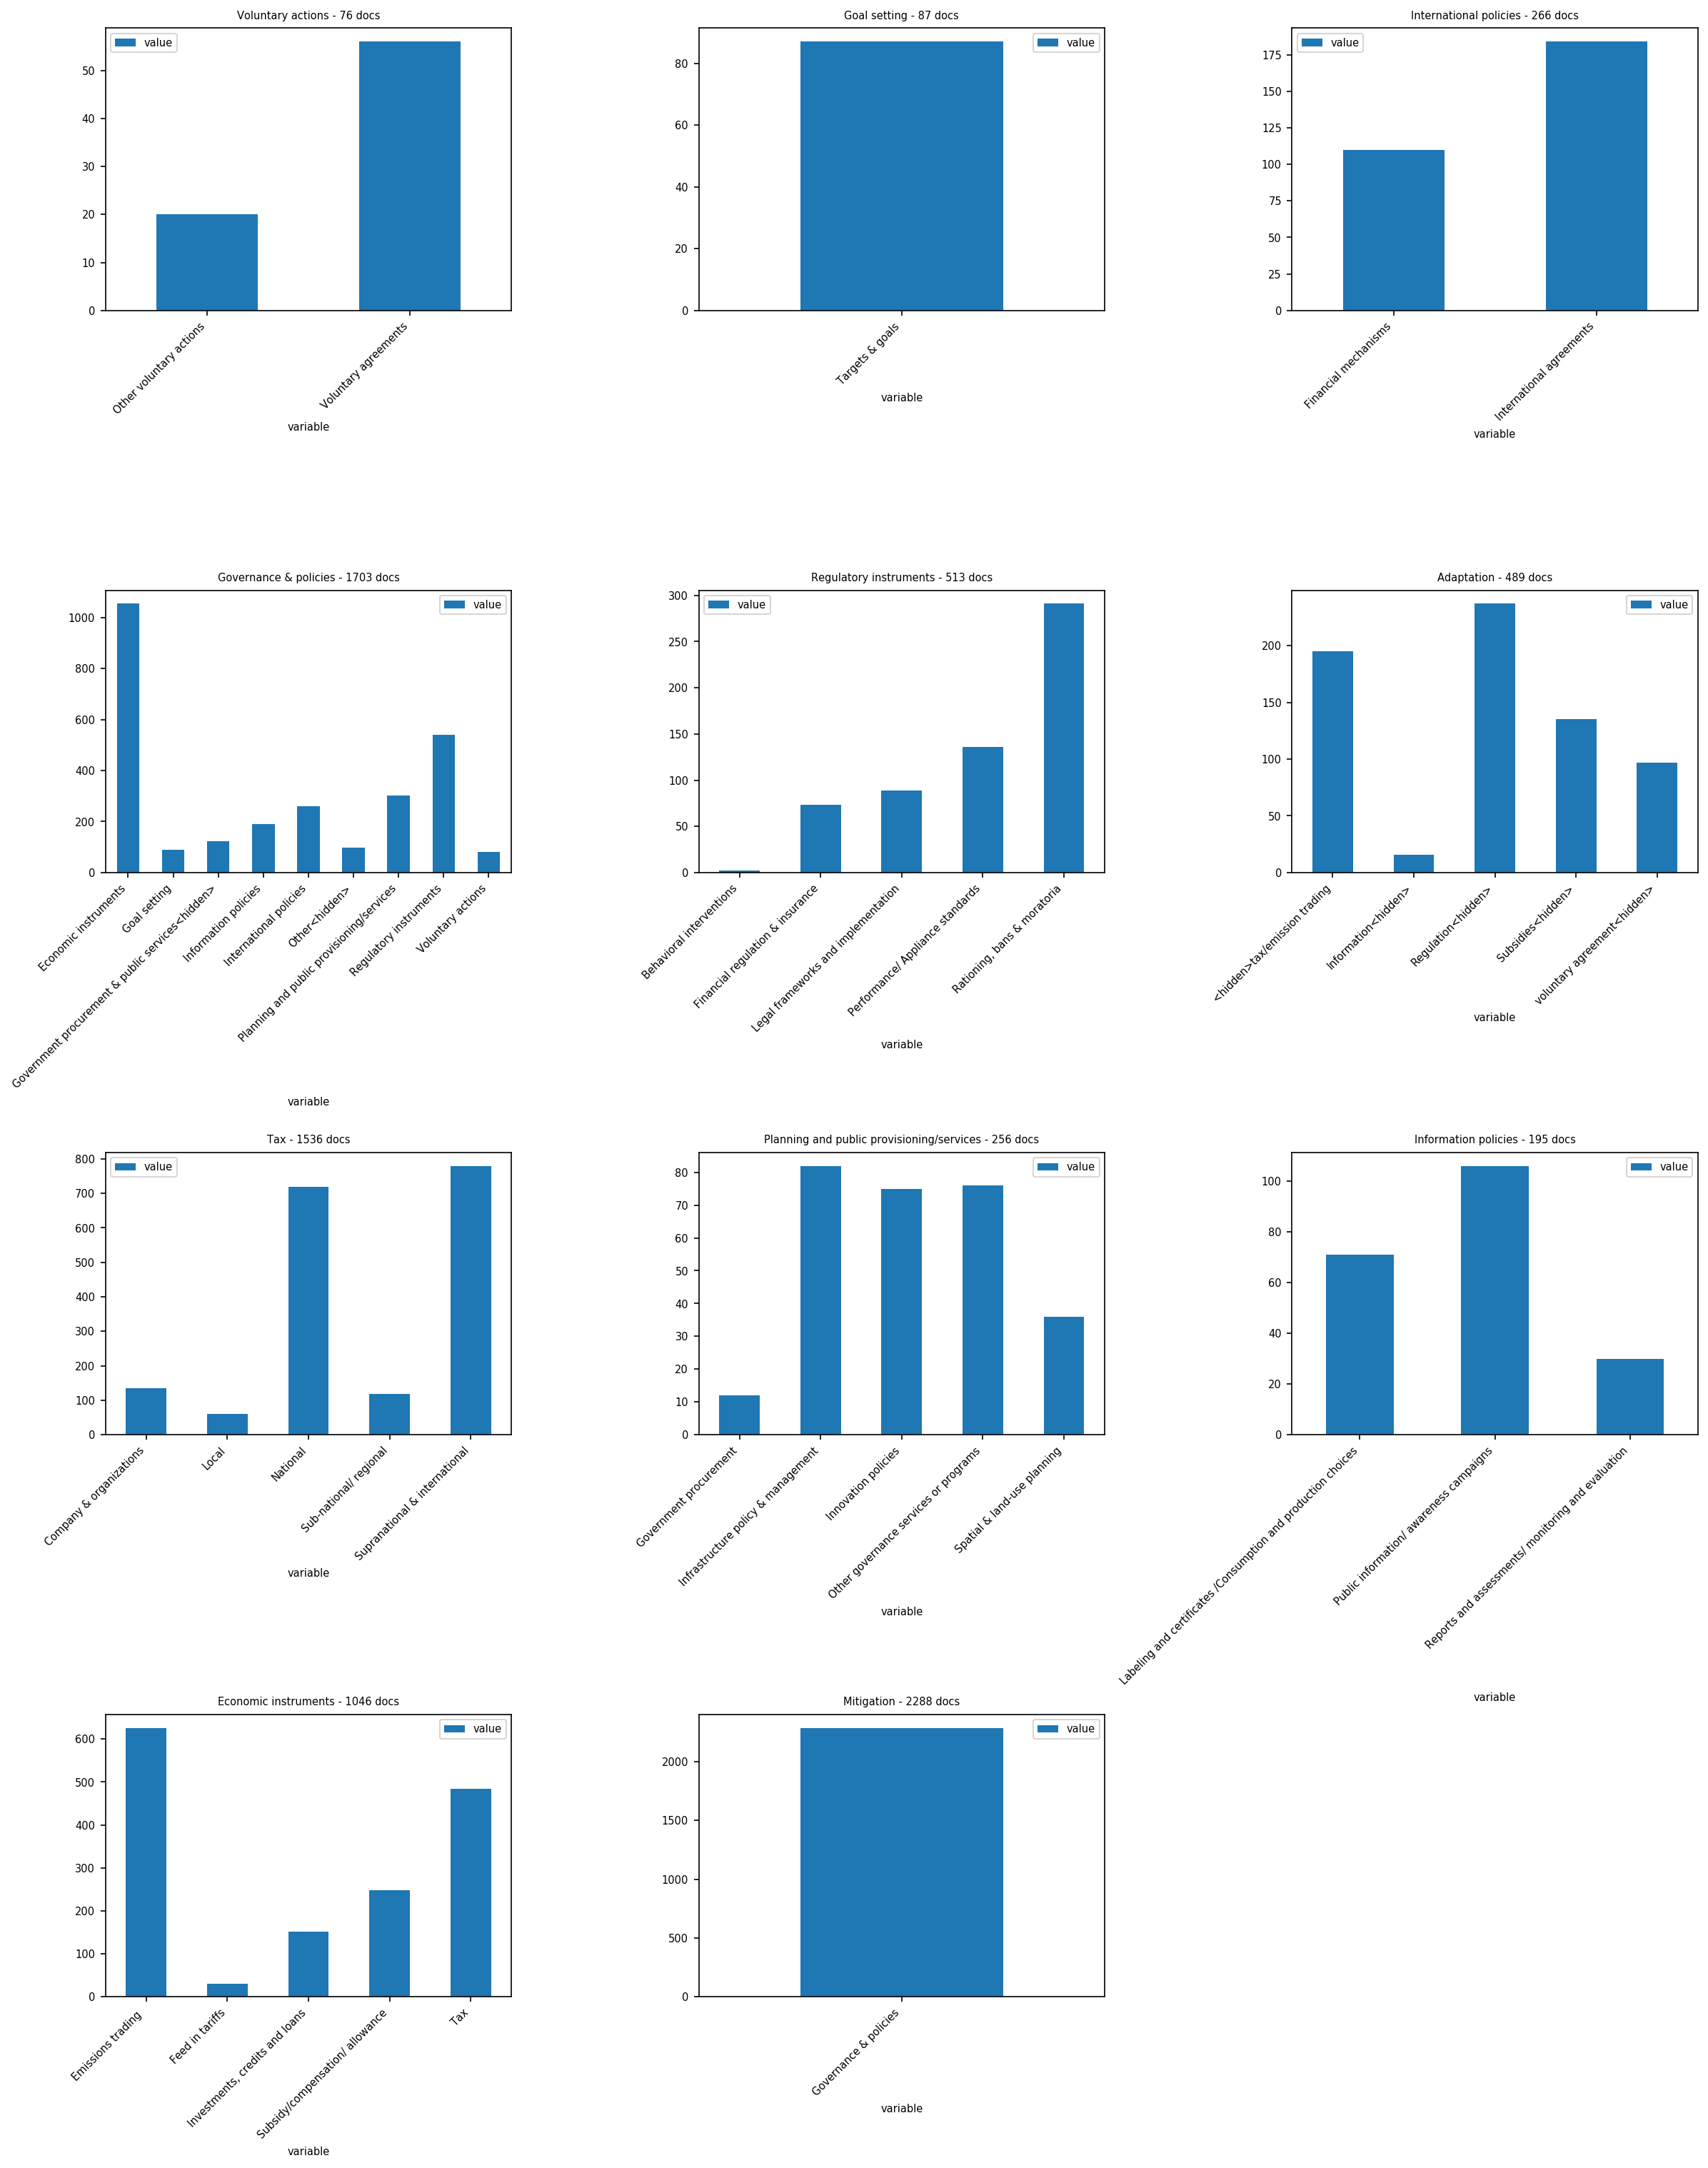

In [45]:
fig = plt.figure(figsize=(16,24),dpi=150)
for i, (n, v) in enumerate(cat_dict.items()):
    v = df.columns.intersection(v)
    ax = fig.add_subplot(5,3,i+1)
    pdf = df.loc[df['relevant']==1,v] 
    pdf['any'] = pdf.sum(axis=1)
    ndocs = pdf['any'].astype("bool").sum()
    pdf = pdf[v].melt()
    
    pdf.groupby('variable').sum().plot.bar(ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha="right")
    ax.set_title(f"{n} - {ndocs} docs")
    
fig.tight_layout()

In [46]:
classes = cat_dict['Governance & policies']
y = np.matrix(df[classes])
print(y.shape)

(94878, 9)


In [47]:
from sklearn.model_selection import KFold
multimodels_gov = [
    {
        'title': 'One vs rest SVC', 
        'model': OneVsRestClassifier(SVC(kernel='linear', probability=True))
    },
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
]

multimodels_gov, metrics_gov = lu.cross_validate_models(ab_X, y, multimodels_gov, seen_index, classes=classes)

1


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


2


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


3


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


4


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


5


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


6


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


7


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


8


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


9


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


10


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


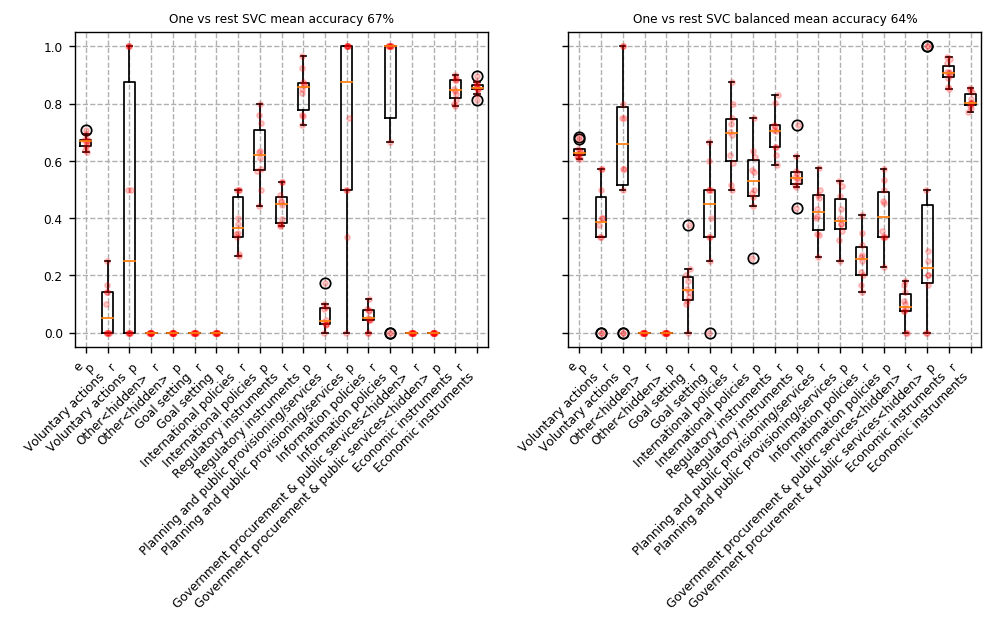

In [49]:
fig, axs = plt.subplots(1, len(multimodels_gov),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels_gov, metrics_gov, fig, axs)
plt.show()

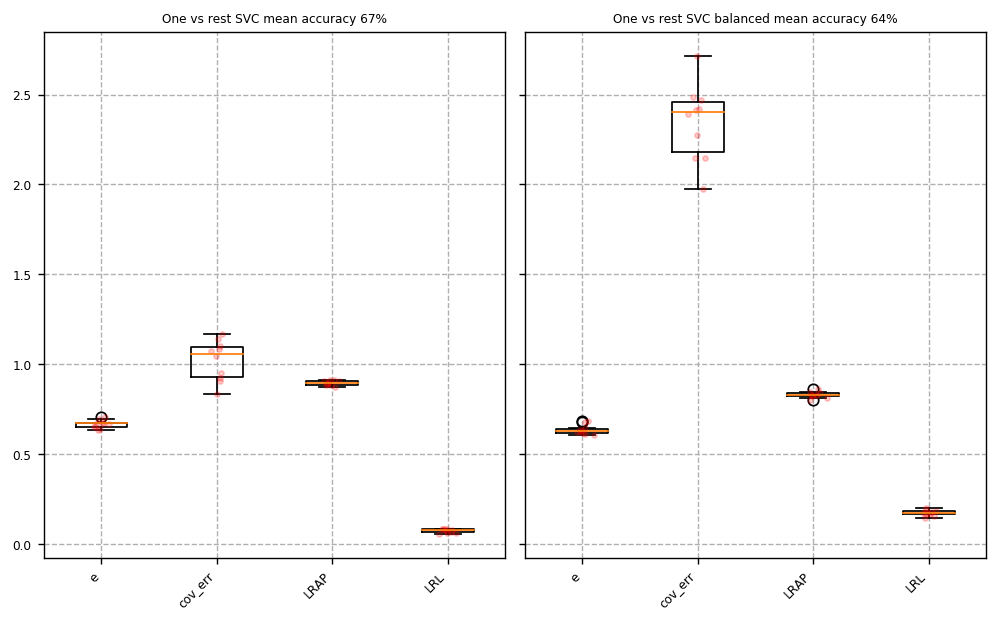

In [50]:
fig, axs = plt.subplots(1, len(multimodels_gov),dpi=125,figsize=(8,5),sharey=True)              
lu.plot_model_output(multimodels_gov, m_metrics, fig, axs)
plt.show()

In [52]:
model_df = pd.DataFrame(multimodels_gov)
model_df.to_csv(f"doctables/multimodels_gov_{now}.csv",index=False)